<a href="https://colab.research.google.com/github/jesseg102/Retail_Analysis/blob/Sultan-Branch/ads_599_Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import pandas as pd

#import pymysql as mysql
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import joblib

from sqlalchemy import create_engine

In [2]:
!pip install scikit-learn==1.2.2


In [ ]:
!pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
#
retail_data_clean = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/retail_data_clean.csv')
transactions_details = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/transaction_details.csv')
transactions_logistics = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/transaction_logistics.csv')
product_info = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/product_info.csv')
customer_info = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/customer_info.csv')
feedback = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/feedback.csv')
champion_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/Champion_classifer_detection.csv')
classifer_detection = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/classifer_detection.csv')

In [ ]:
df_labeled = classifer_detection.copy()
df_labeled.shape
scaler = StandardScaler()
numerical_features = df_labeled.select_dtypes(include=['float64', 'int64']).columns
df_labeled[numerical_features] = scaler.fit_transform(df_labeled[numerical_features])

df_labeled['RFM_Segment'].value_counts()

RFM_Segment
Champions              91293
Potential Loyalists    77391
Loyal Customers        52683
At-Risk                27676
Hibernating            21031
Others                 19295
Big Spenders           11380
Name: count, dtype: int64

In [6]:
df_labeled = classifer_detection.copy()
df_labeled.shape
scaler = StandardScaler()
numerical_features = df_labeled.select_dtypes(include=['float64', 'int64']).columns
df_labeled[numerical_features] = scaler.fit_transform(df_labeled[numerical_features])

le = LabelEncoder()

df_labeled['RFM_Segment'] = le.fit_transform(df_labeled['RFM_Segment'])
df_labeled["CLV_Segment"] = le.fit_transform(df_labeled["CLV_Segment"])
df_labeled["Feedback"] = le.fit_transform(df_labeled["Feedback"])
df_labeled["Segment"] = le.fit_transform(df_labeled["Segment"])

# One-hot encode the 'products' column
df_products = pd.get_dummies(df_labeled['products'], prefix='product')

# Drop original 'products' column from df_labeled
df_labeled.drop(['products', 'Date', 'Time', 'Month'], axis=1, inplace=True)

# Merge the one-hot encoded product columns back to df_labeled
df_labeled = pd.concat([df_labeled, df_products], axis=1)

# Define features (X) and target (y)
X = df_labeled.drop(['RFM_Segment'], axis=1)
y = df_labeled['RFM_Segment']


In [8]:
categorical_cols = X.select_dtypes(include=['object']).columns

if len(categorical_cols) > 0:
    print(f"Categorical columns found: {categorical_cols.tolist()}")
    # Step 2: Encode categorical columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"Shape of X after encoding: {X.shape}")
else:
    print("No categorical columns found.")

No categorical columns found.


### Random Forest

In [ ]:

import joblib


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the Random Forest model with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Get feature importances
importances = rf_best.feature_importances_

# Sort feature importances in descending order and select top features
indices = np.argsort(importances)[::-1]
selected_features = indices[:100]  # Select top 100 features

# Transform the data to select only important features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Check selected features
selected_features_names = np.array(X.columns)[selected_features]
print(f'Selected features: {selected_features_names}')

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_train_selected):
    X_ktrain, X_val = X_train_selected[train_index], X_train_selected[val_index]
    y_ktrain, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    rf_best.fit(X_ktrain, y_ktrain)

    # Make predictions
    y_val_pred = rf_best.predict(X_val)

    # Evaluate the model
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    accuracy = accuracy_score(y_val, y_val_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculate average metrics
avg_precision_rf = np.mean(precision_scores)
avg_recall_rf = np.mean(recall_scores)
avg_f1_rf = np.mean(f1_scores)
avg_accuracy_rf = np.mean(accuracy_scores)

print(f'Average Precision Random Forest: {avg_precision_rf:.2f}')
print(f'Average Recall Random Forest: {avg_recall_rf:.2f}')
print(f'Average F1 Score Random Forest: {avg_f1_rf:.2f}')
print(f'Average Accuracy Random Forest: {avg_accuracy_rf:.2f}')

# Train the model on the entire training data
rf_best.fit(X_train_selected, y_train)

# Make predictions on the test data
y_test_pred = rf_best.predict(X_test_selected)

# Evaluate the model on the test data
test_precision_rf = precision_score(y_test, y_test_pred, average='weighted')
test_recall_rf = recall_score(y_test, y_test_pred, average='weighted')
test_f1_rf = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy_rf = accuracy_score(y_test, y_test_pred)

print(f'Test Precision Random Forest: {test_precision_rf:.2f}')
print(f'Test Recall Random Forest: {test_recall_rf:.2f}')
print(f'Test F1 Score Random Forest: {test_f1_rf:.2f}')
print(f'Test Accuracy Random Forest: {test_accuracy_rf:.2f}')

# Save the model
joblib.dump(rf_best, '/content/drive/MyDrive/Colab_Notebooks/data/Random_Forest_Hyper_Tuned.pkl')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Selected features: ['Total_Purchases_count' 'Total_Amount_sum' 'Total_Purchases_sum' 'Year'
 'Total_Amount_mean' 'CLV' 'Customer_ID' 'Quarter' 'Total_Purchases_mean'
 'Unnamed: 0' 'Total_Amount' 'Amount' 'Age_Total_Amount' 'Transaction_ID'
 'Day' 'Hour' 'Age' 'Total_Purchases' 'Weekday' 'CLV_Segment' 'Ratings'
 'Feedback' 'Segment' 'Gender_Male' 'Shipping_Method_Same-Day'
 'Shipping_Method_Standard' 'Customer_Segment_Regular'
 'Payment_Method_Credit Card' 'Payment_Method_Debit Card' 'Income_Medium'
 'Payment_Method_PayPal' 'Income_Low' 'Order_Status_Shipped'
 'Order_Status_Processing' 'Customer_Segment_Premium'
 'Order_Status_Pending' 'Country_USA' 'Product_Category_Electronics'
 'Product_Category_Grocery' 'Product_Category_Clothing'
 'Product_Category_Home Decor' 'Country_UK' 'State_New South Wales'
 'State_England' 'State_Berlin' 'Country_Germany' 'State_Ontari

['/content/drive/MyDrive/Colab_Notebooks/data/Random_Forest_Hyper_Tuned.pkl']

### Decision Tree

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Average Precision Decision Tree: 0.74
Average Recall Decision Tree: 0.74
Average F1 Score Decision Tree: 0.74
Average Accuracy Decision Tree: 0.74
Test Precision Decision Tree: 0.79
Test Recall Decision Tree: 0.79
Test F1 Score Decision Tree: 0.79
Test Accuracy Decision Tree: 0.79


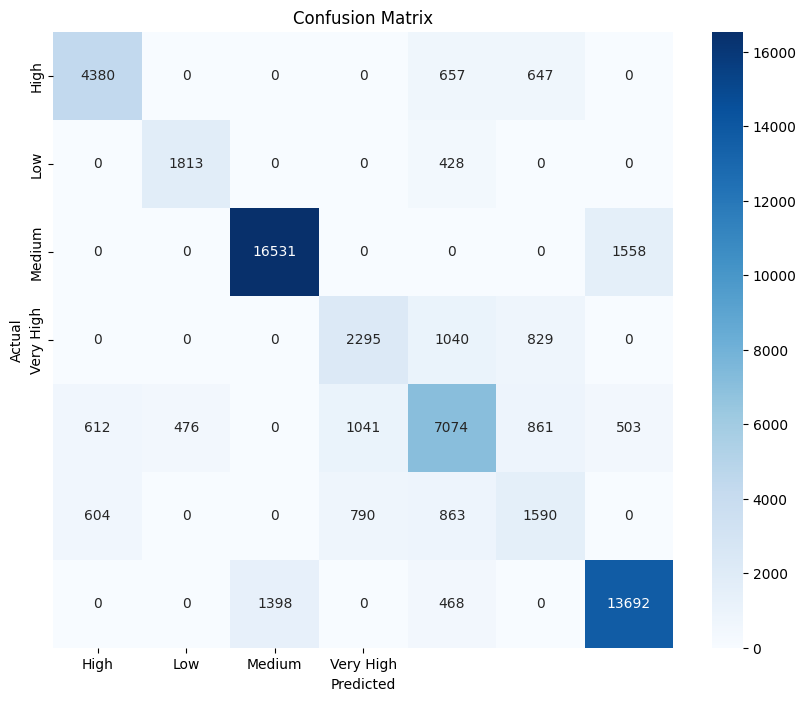

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Assuming X and y are already defined
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Define GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the Decision Tree model with the best parameters
dt_best = DecisionTreeClassifier(**best_params, random_state=42)
dt_best.fit(X_train, y_train)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_train):
    X_ktrain, X_val = X_train[train_index], X_train[val_index]
    y_ktrain, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    dt_best.fit(X_ktrain, y_ktrain)

    # Make predictions
    y_val_pred = dt_best.predict(X_val)

    # Evaluate the model
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    accuracy = accuracy_score(y_val, y_val_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculate average metrics
avg_precision_dt = np.mean(precision_scores)
avg_recall_dt = np.mean(recall_scores)
avg_f1_dt = np.mean(f1_scores)
avg_accuracy_dt = np.mean(accuracy_scores)

print(f'Average Precision Decision Tree: {avg_precision_dt:.2f}')
print(f'Average Recall Decision Tree: {avg_recall_dt:.2f}')
print(f'Average F1 Score Decision Tree: {avg_f1_dt:.2f}')
print(f'Average Accuracy Decision Tree: {avg_accuracy_dt:.2f}')

# Train the model on the entire training data
dt_best.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = dt_best.predict(X_test)

# Evaluate the model on the test data
test_precision_dt = precision_score(y_test, y_test_pred, average='weighted')
test_recall_dt = recall_score(y_test, y_test_pred, average='weighted')
test_f1_dt = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy_dt = accuracy_score(y_test, y_test_pred)

print(f'Test Precision Decision Tree: {test_precision_dt:.2f}')
print(f'Test Recall Decision Tree: {test_recall_dt:.2f}')
print(f'Test F1 Score Decision Tree: {test_f1_dt:.2f}')
print(f'Test Accuracy Decision Tree: {test_accuracy_dt:.2f}')


conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Save the model


In [ ]:
joblib.dump(dt_best, '/content/drive/MyDrive/Colab_Notebooks/data/Decision_Tree_Hyper_Tuned.pkl')


['/content/drive/MyDrive/Colab_Notebooks/data/Decision_Tree_Hyper_Tuned.pkl']

In [ ]:
df_labeled['RFM_Segment'].value_counts()

RFM_Segment
Champions              91293
Potential Loyalists    77391
Loyal Customers        52683
At-Risk                27676
Hibernating            21031
Others                 19295
Big Spenders           11380
Name: count, dtype: int64

### XGboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import xgboost as xgb
import joblib

# Split data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the validation set
grid_search.fit(X_val, y_val)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the XGBoost model with the best parameters on the entire training data
xgb_best = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_best.fit(np.vstack((X_train, X_val)), np.concatenate((y_train, y_val)))

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_train):
    X_ktrain, X_kval = X_train[train_index], X_train[val_index]
    y_ktrain, y_kval = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    xgb_best.fit(X_ktrain, y_ktrain)

    # Make predictions
    y_val_pred = xgb_best.predict(X_kval)

    # Evaluate the model
    precision = precision_score(y_kval, y_val_pred, average='weighted')
    recall = recall_score(y_kval, y_val_pred, average='weighted')
    f1 = f1_score(y_kval, y_val_pred, average='weighted')
    accuracy = accuracy_score(y_kval, y_val_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculate average metrics
avg_precision_xgb = np.mean(precision_scores)
avg_recall_xgb = np.mean(recall_scores)
avg_f1_xgb = np.mean(f1_scores)
avg_accuracy_xgb = np.mean(accuracy_scores)

print(f'Average Precision XGBoost: {avg_precision_xgb:.2f}')
print(f'Average Recall XGBoost: {avg_recall_xgb:.2f}')
print(f'Average F1 Score XGBoost: {avg_f1_xgb:.2f}')
print(f'Average Accuracy XGBoost: {avg_accuracy_xgb:.2f}')

# Make predictions on the test data
y_test_pred = xgb_best.predict(X_test)

# Evaluate the model on the test data
test_precision_xgb = precision_score(y_test, y_test_pred, average='weighted')
test_recall_xgb = recall_score(y_test, y_test_pred, average='weighted')
test_f1_xgb = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy_xgb = accuracy_score(y_test, y_test_pred)

print(f'Test Precision XGBoost: {test_precision_xgb:.2f}')
print(f'Test Recall XGBoost: {test_recall_xgb:.2f}')
print(f'Test F1 Score XGBoost: {test_f1_xgb:.2f}')
print(f'Test Accuracy XGBoost: {test_accuracy_xgb:.2f}')

# Save the model
joblib.dump(xgb_best, '/content/drive/MyDrive/Colab_Notebooks/data/XGBoost_Hyper_Tuned.pkl')


In [ ]:
joblib.dump(xgb_best, '/content/drive/MyDrive/Colab_Notebooks/data/XGBoost_Hyper_Tuned.pkl')


['/content/drive/MyDrive/Colab_Notebooks/data/XGBoost_Hyper_Tuned.pkl']

In [7]:
import joblib
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the saved model
xgb_best = joblib.load('/content/drive/MyDrive/Colab_Notebooks/data/XGBoost_Hyper_Tuned.pkl')

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the test data if not already done
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# Make predictions on the test data
y_test_pred = xgb_best.predict(X_test)

# Evaluate the model on the test data
test_precision_xgb = precision_score(y_test, y_test_pred, average='weighted')
test_recall_xgb = recall_score(y_test, y_test_pred, average='weighted')
test_f1_xgb = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy_xgb = accuracy_score(y_test, y_test_pred)

print(f'Test Precision XGBoost: {test_precision_xgb:.2f}')
print(f'Test Recall XGBoost: {test_recall_xgb:.2f}')
print(f'Test F1 Score XGBoost: {test_f1_xgb:.2f}')
print(f'Test Accuracy XGBoost: {test_accuracy_xgb:.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:24:33] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Test Precision XGBoost: 0.68
Test Recall XGBoost: 0.66
Test F1 Score XGBoost: 0.64
Test Accuracy XGBoost: 0.66


### Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np


# Split data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())

    val_loss /= len(val_loader.dataset)
    val_precision = precision_score(all_labels, all_preds, average='weighted')
    val_recall = recall_score(all_labels, all_preds, average='weighted')
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_accuracy = accuracy_score(all_labels, all_preds)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Precision: {val_precision:.4f}, '
          f'Val Recall: {val_recall:.4f}, '
          f'Val F1 Score: {val_f1:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test data
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

test_loss /= len(test_loader.dataset)
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_accuracy = accuracy_score(all_labels, all_preds)

print(f'Test Loss: {test_loss:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1 Score: {test_f1:.4f}, '
      f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/data/neural_network_model.pth')


Epoch 1/20, Train Loss: 1.0081, Val Loss: 0.8050, Val Precision: 0.6057, Val Recall: 0.6081, Val F1 Score: 0.5857, Val Accuracy: 0.6081
Epoch 2/20, Train Loss: 0.8712, Val Loss: 0.7798, Val Precision: 0.6080, Val Recall: 0.6085, Val F1 Score: 0.5728, Val Accuracy: 0.6085
Epoch 3/20, Train Loss: 0.8414, Val Loss: 0.7586, Val Precision: 0.6390, Val Recall: 0.6161, Val F1 Score: 0.5912, Val Accuracy: 0.6161
Epoch 4/20, Train Loss: 0.8261, Val Loss: 0.7582, Val Precision: 0.6666, Val Recall: 0.5836, Val F1 Score: 0.5327, Val Accuracy: 0.5836


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/20, Train Loss: 0.8142, Val Loss: 0.7530, Val Precision: 0.6066, Val Recall: 0.6176, Val F1 Score: 0.5914, Val Accuracy: 0.6176
Epoch 6/20, Train Loss: 0.8098, Val Loss: 0.7395, Val Precision: 0.6311, Val Recall: 0.6263, Val F1 Score: 0.6001, Val Accuracy: 0.6263
Epoch 7/20, Train Loss: 0.8019, Val Loss: 0.7359, Val Precision: 0.6527, Val Recall: 0.6245, Val F1 Score: 0.5998, Val Accuracy: 0.6245
Epoch 8/20, Train Loss: 0.7985, Val Loss: 0.7338, Val Precision: 0.6528, Val Recall: 0.6206, Val F1 Score: 0.6021, Val Accuracy: 0.6206


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/20, Train Loss: 0.7936, Val Loss: 0.7356, Val Precision: 0.6107, Val Recall: 0.6183, Val F1 Score: 0.5784, Val Accuracy: 0.6183
Epoch 10/20, Train Loss: 0.7901, Val Loss: 0.7267, Val Precision: 0.6494, Val Recall: 0.6260, Val F1 Score: 0.5982, Val Accuracy: 0.6260
Epoch 11/20, Train Loss: 0.7900, Val Loss: 0.7276, Val Precision: 0.6411, Val Recall: 0.6248, Val F1 Score: 0.5990, Val Accuracy: 0.6248
Epoch 12/20, Train Loss: 0.7852, Val Loss: 0.7222, Val Precision: 0.6503, Val Recall: 0.6273, Val F1 Score: 0.6024, Val Accuracy: 0.6273
Epoch 13/20, Train Loss: 0.7848, Val Loss: 0.7236, Val Precision: 0.6820, Val Recall: 0.6236, Val F1 Score: 0.5958, Val Accuracy: 0.6236
Epoch 14/20, Train Loss: 0.7821, Val Loss: 0.7282, Val Precision: 0.6594, Val Recall: 0.6211, Val F1 Score: 0.5988, Val Accuracy: 0.6211
Epoch 15/20, Train Loss: 0.7808, Val Loss: 0.7213, Val Precision: 0.6420, Val Recall: 0.6243, Val F1 Score: 0.5902, Val Accuracy: 0.6243
Epoch 16/20, Train Loss: 0.7762, Val Loss: